# 8. Modeling Strategies Assignment & Supervised ML
-- Chuying Tang

In this report, we will use H2O module in Python to train random forests models on a mortgage default dataset. Also, we will experiment at least two sampling methods (either under-sampling or over-sampling techniques) to increase your predictability.



# Table of Contents <a class="anchor" id="0"></a>
- <b>[1. Data Preparation](#1)</b>
- <b>[2. H2O Introduction](#2)</b>
- <b>[3. Build basic model and Create Metrics Functions](#3)</b>
- <b>[4. Building a simple decision tree model](#4)</b>
- <b>[5. Conclusion](#5)</b>

       
  <p>&nbsp;</p>

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Data Preparation <a class="anchor" id="1"></a>

In [5]:
# load data
path = '/Users/mac/Downloads/' 
data = pd.read_csv(path + 'XYZloan_default_selected_vars.csv')  
data.tail()

,Unnamed: 0.1,Unnamed: 0,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
79995,79995,79996,79996,0,39,2,1,12,2017/5/7 13:44,android,...,15.0,8.0,864.0,684.0,1261.0,764.0,2600.0,1074.0,11.0,OPPO
79996,79996,79997,79997,0,31,1,4,12,2017/6/2 15:54,ios,...,25.0,25.0,6177.0,6177.0,6426.0,6426.0,6426.0,6426.0,6.0,IPHONE7
79997,79997,79998,79998,0,37,1,1,12,2017/7/9 8:40,android,...,14.0,13.0,1116.0,1116.0,2061.0,2061.0,2501.0,2061.0,12.0,VIVO
79998,79998,79999,79999,0,38,2,1,12,2017/5/9 10:19,android,...,5.0,2.0,25.0,0.0,498.0,343.0,514.0,343.0,6.0,XIAOMI
79999,79999,80000,80000,1,25,1,3,12,2017/4/27 18:36,h5,...,9.0,9.0,129.0,129.0,167.0,167.0,167.0,167.0,7.0,WEB


In [34]:
# split the data for modeling
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.20, random_state=42) 

In [35]:
train.shape

(64000, 89)

In [36]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [37]:
# change the colum names of var dataframe
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [38]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [39]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [40]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [41]:
train['loan_default'].value_counts(dropna=False)

0    51662
1    12338
Name: loan_default, dtype: int64

In [53]:
class_normal = train['loan_default'].value_counts(dropna=False)[0]
class_abnormal = train['loan_default'].value_counts(dropna=False)[1]
rate = class_abnormal/(class_normal + class_abnormal)
print(rate)

0.19278125


There are 19% of data that are abnormal in this data set, which means that the data is imbalanced. We will use balance_classes in H2O to solve this problem later.

## 2. H2O Introduction <a class="anchor" id="2"></a>

In [16]:
# !pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 MB 4.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.38.0.1-py2.py3-none-any.whl size=177276478 sha256=045f0a654f0dd4a0f4e1a4169688741bfac11227e614970882dc230d0584d821
  Stored in directory: /Users/mac/Library/Caches/pip/wheels/66/49/5c/3e1189c822f4b655c4c1898221a12d834872b7474a76408a26
Successfully built h2o


In [20]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "19" 2022-09-20; Java(TM) SE Runtime Environment (build 19+36-2238); Java HotSpot(TM) 64-Bit Server VM (build 19+36-2238, mixed mode, sharing)
  Starting server from /Users/mac/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6y/dd1qh2x900v5tw238ssc4psw0000gn/T/tmpoh82olp0
  JVM stdout: /var/folders/6y/dd1qh2x900v5tw238ssc4psw0000gn/T/tmpoh82olp0/h2o_mac_started_from_python.out
  JVM stderr: /var/folders/6y/dd1qh2x900v5tw238ssc4psw0000gn/T/tmpoh82olp0/h2o_mac_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_mac_j5oigl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [21]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [18]:
target='loan_default'

## 3. Build basic model and Create Metrics Functions <a class="anchor" id="3"></a>

In [42]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [43]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [44]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         138625                 7            13           9.17          27            34            29.9667

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.1479603152277468
RMSE: 0.38465609994870326
MAE: 0.2967623200938879
RMSLE: 0.26971458927605063
Mean Residual Deviance: 0.1479603152277468

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14814993564319848
RMSE: 0.3849025014769305
MAE: 0.296882979842838
RMSLE: 0.26987607522105317
Mean Residual Deviance: 0.14814993564319848

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.296949   0.00712503  0.308968      0.293851      0.298243      0.289581      0.298103      0.300175      0.290924      0.305441      0.285788      0.298419
mean_residual_deviance  0.148161   0.00821841  0.161214      0.143425      0.152246      0.14226       0.149569      0.154964      0.138832      0.15678       0.135871      0.146448
mse                     0.148161   0.00821841  0.161214      0.143425      0.152246      0.14226       0.149569      0.154964      0.138832      0.15678       0.135871      0.146448
r2                      0.0323535  0.0148616   0.0274963     0.0235608     0.0288095     0.0223095     0.0247649     0.0397118     0.0258111     0.0706391     0.0217309     0.0387007
residual_deviance       0.148161   0.00821841  0.161214      0.143425      0.152246      0.14226       0.149569      0.154964      0.138832      0.15678       0.135871      0.146448
rmse                    0.384783   0.0106754   0.401514      0.378715      0.390187      0.377173      0.386742      0.393654      0.372602      0.395955      0.368606      0.382685
rmsle                   0.269844   0.00517202  0.279088      0.267474      0.272555      0.265747      0.271488      0.273544      0.264226      0.273438      0.261842      0.269042

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2022-10-16 11:24:36  6.072 sec   0.0                nan                  nan                  nan
     2022-10-16 11:24:36  6.078 sec   1.0                0.38595677948093376  0.29264966642146867  0.14896263562729414
     2022-10-16 11:24:36  6.082 sec   2.0                0.389069365548645    0.2968386017135832   0.15137497120842516
     2022-10-16 11:24:36  6.085 sec   3.0                0.38579620670974957  0.2950468144324008   0.14883871311163183
     2022-10-16 11:24:36  6.090 sec   4.0                0.3851102313296535   0.29464734035441725  0.14830989027477923
     2022-10-16 11:24:36  6.094 sec   5.0                0.386312325912977    0.2963549659096571   0.14923721315229413
     2022-10-16 11:24:36  6.098 sec   6.0                0.3866845300021303   0.2966641759892833   0.14952492574296844
     2022-10-16 11:24:36  6.105 sec   7.0                0.38687986916015205  0.2971675467674455   0.14967603316137637
     2022-10-16 11:24:36  6.110 sec   8.0                0.3870934155085469   0.29731653572507616  0.14984131233007256
     2022-10

#### Variable Importance

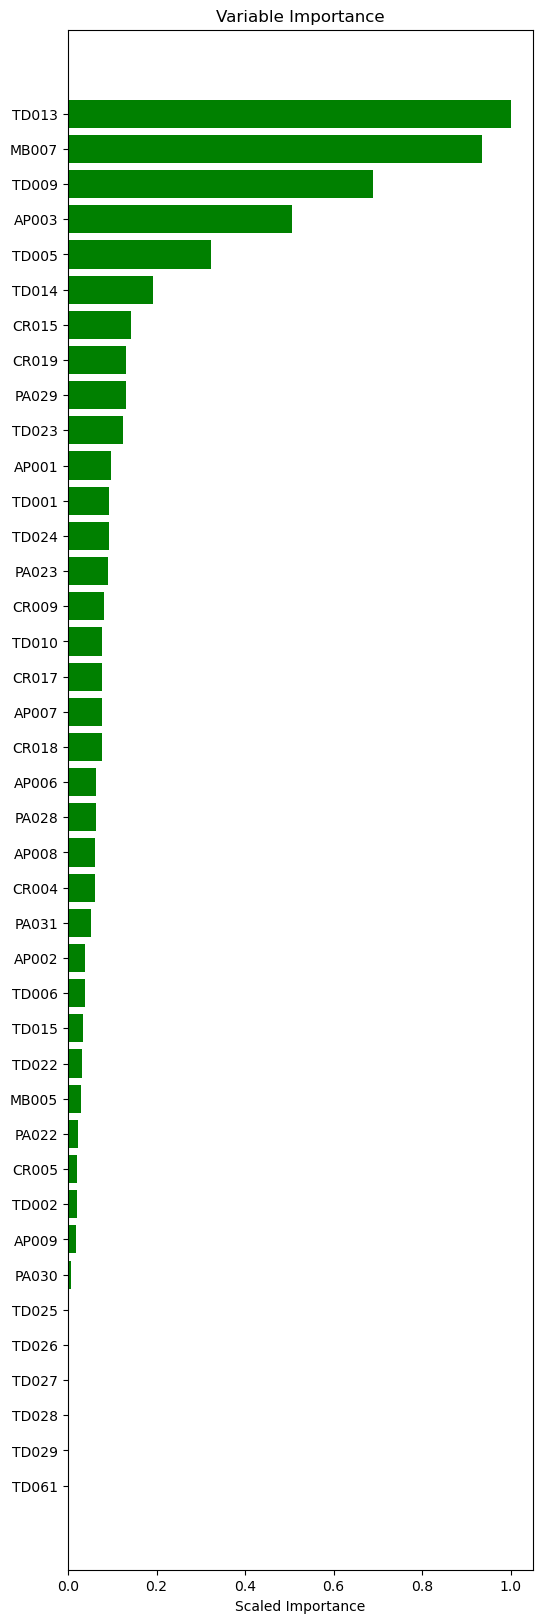

In [45]:
# define a function to visualize variable importance
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(rf_v1)

In [46]:
predictions = rf_v1.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,loan_default,predict
0,0,0.284682
1,0,0.261607
2,0,0.214783
3,0,0.104449
4,0,0.183126


Here we define functions to generate gains table and ROC/AUC. We will first use a portion of dataset to validate that our self defined functions are application. We will then apply the functions to the whole dataset. 

### Gains Table
A Gains Chart can serve two great purposes to help our business strategies: (i) selecting the better-performing model, and (ii) deciding which segments to target. In this case, we will use it to select the better-performing model to detect the loan faults.

In [47]:
# define a function to conduct gains table
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(rf_v1)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,160,50,110,160,50,110,0.17,0.08,30.0,1.67,9.0,31.25
1,160,41,119,320,91,229,0.30,0.18,60.0,1.52,12.0,28.44
2,160,46,114,480,137,343,0.46,0.26,90.0,1.52,20.0,28.54
3,160,28,132,640,165,475,0.55,0.37,120.0,1.38,18.0,25.78
4,160,34,126,800,199,601,0.66,0.46,150.0,1.33,20.0,24.88
5,160,23,137,960,222,738,0.74,0.57,180.0,1.23,17.0,23.12
6,160,22,138,1120,244,876,0.81,0.67,210.0,1.16,14.0,21.79
7,160,26,134,1280,270,1010,0.90,0.78,240.0,1.12,12.0,21.09
8,160,16,144,1440,286,1154,0.95,0.89,270.0,1.06,6.0,19.86


### ROC (Receiver Operating Characteristic) & AUC (Area Under the Curve)
The receiver operating characteristic (ROC) curve is one of the most effective evaluation metrics because it visualizes the accuracy of predictions for a whole range of cutoff values.If we had a perfect model, the ROC curve would pass through the upper left corner — indicating no error. A better model is when the ROC is close to the upper left corner.  
The most important parameter that can be obtained from a ROC curve is the Area Under the Curve (AUC). For a perfect model, the area under the curve would be 1.0.

In [28]:
# define a functiont to calculate ROC_AUC
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



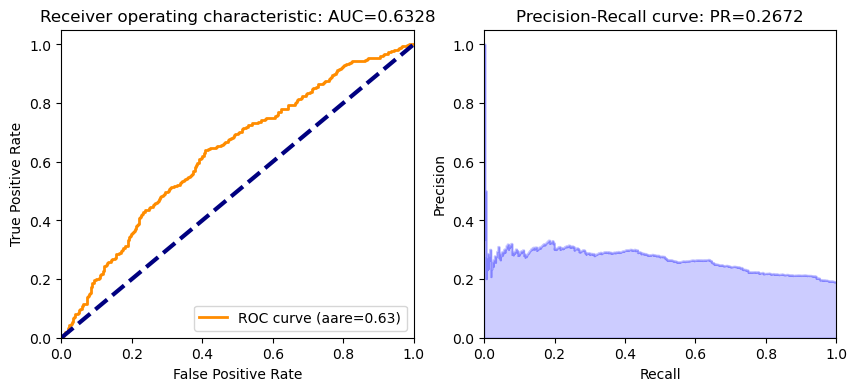

In [48]:
ROC_AUC(rf_v1,test_hex,'loan_default')

Figure above shows that the AUC is 0.6328.

#### Now the code works fine with the small dataset, we can model with the entire dataset

In [49]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v2.train(predictors,target,training_frame=train_hex)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         1.29284e+06            14           19           15.8533       289           315           303.43

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14773110691617203
RMSE: 0.3843580452080742
MAE: 0.2966461289110395
RMSLE: 0.26944207177693574
Mean Residual Deviance: 0.14773110691617203

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14771911888095124
RMSE: 0.38434245001164163
MAE: 0.2967477145135069
RMSLE: 0.26941874944186084
Mean Residual Deviance: 0.14771911888095124

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.296762   0.00364869  0.30054       0.301814      0.298269      0.29445       0.292679      0.290095      0.298161      0.294864      0.298887      0.297859
mean_residual_deviance  0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
mse                     0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
r2                      0.0505053  0.00484609  0.050743      0.0453925     0.0569733     0.0486312     0.043897      0.054541      0.0586001     0.0486646     0.047198      0.0504118
residual_deviance       0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
rmse                    0.384336   0.00464263  0.38965       0.391252      0.385695      0.38158       0.379652      0.375987      0.386017      0.381757      0.387014      0.384751
rmsle                   0.269419   0.00256337  0.272212      0.273413      0.269903      0.267952      0.267093      0.264646      0.269963      0.268142      0.271074      0.269791

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2022-10-16 11:27:29  1 min 50.785 sec  0.0                nan                  nan                  nan
     2022-10-16 11:27:29  1 min 50.820 sec  1.0                0.3931051720152582   0.2973677407074112   0.15453167626514572
     2022-10-16 11:27:29  1 min 50.851 sec  2.0                0.3932387646033005   0.2985421823954527   0.15463672598672998
     2022-10-16 11:27:29  1 min 50.882 sec  3.0                0.3910245536572394   0.29783530208807024  0.1529002015628433
     2022-10-16 11:27:29  1 min 50.914 sec  4.0                0.38977464713194915  0.2972853100116862   0.15192427554683546
     2022-10-16 11:27:29  1 min 50.946 sec  5.0                0.3893192665932578   0.2970973391076467   0.1515694913407121
     2022-10-16 11:27:29  1 min 50.977 sec  6.0                0.38845957435645107  0.2970509353003981   0.15090084090919512
     2022-10-16 11:27:29  1 min 51.010 sec  7.0                0.3879896161135647   0.29727233983554996  0.1505359422119513
     2022-10-16 11:27:29  1 min 51.040 sec  8.0                0.3877077

In [51]:
createGains(rf_v2)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,619,981,1600,619,981,0.20,0.08,315.0,1.97,12.0,38.69
1,1600,484,1116,3200,1103,2097,0.35,0.16,630.0,1.75,19.0,34.47
2,1600,392,1208,4800,1495,3305,0.47,0.26,945.0,1.58,21.0,31.15
3,1600,362,1238,6400,1857,4543,0.59,0.35,1260.0,1.47,24.0,29.02
4,1600,322,1278,8000,2179,5821,0.69,0.45,1575.0,1.38,24.0,27.24
5,1600,260,1340,9600,2439,7161,0.77,0.56,1890.0,1.29,21.0,25.41
6,1600,239,1361,11200,2678,8522,0.85,0.66,2205.0,1.21,19.0,23.91
7,1600,205,1395,12800,2883,9917,0.92,0.77,2520.0,1.14,15.0,22.52
8,1600,154,1446,14400,3037,11363,0.96,0.88,2835.0,1.07,8.0,21.09


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



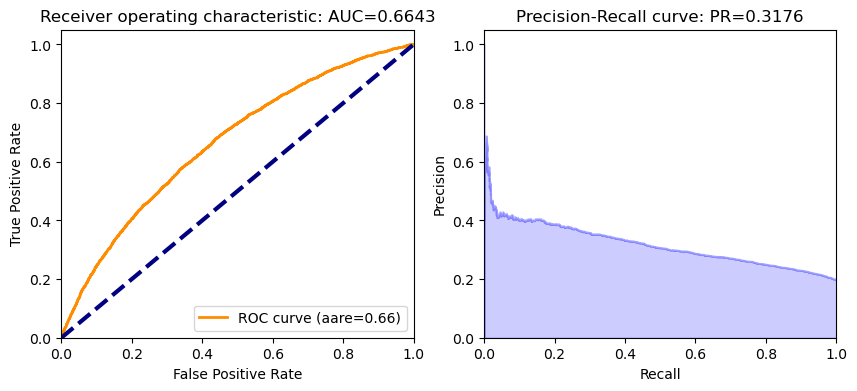

In [52]:
ROC_AUC(rf_v2,test_hex,'loan_default')

The orange curve is the ROC curve. The above plot with 0.6643 ROC means that the model result is slightly better than a completely random draw(blue line).

#### [Back to the top](#0)

## 4. Improve the models  with Resampling Methods
<a class="anchor" id="4"></a>

The dataset is imbalanced as it one of the classes, the abnormal data, constitutes only a very small minority(19%). AUC does not place more emphasis on one class over the other, so it does not reflect the minority class well.   
Therefore, we will use 'balance_classes' in H2O module and data sampling techniques to handle the imbalanced data.

### Use H2O's "balance_classes"
The balance_classes option can be used to balance the class distribution. When enabled, H2O will either undersample the majority classes or oversample the minority classes.

In [54]:
rf_v3 = H2ORandomForestEstimator(
        model_id = 'rf_v3',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        balance_classes = True,
        seed=1234)
rf_v3.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         1.29286e+06            14           19           15.8533       289           315           303.43

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14773110691617203
RMSE: 0.3843580452080742
MAE: 0.2966461289110395
RMSLE: 0.26944207177693574
Mean Residual Deviance: 0.14773110691617203

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14771911888095124
RMSE: 0.38434245001164163
MAE: 0.2967477145135069
RMSLE: 0.26941874944186084
Mean Residual Deviance: 0.14771911888095124

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.296762   0.00364869  0.30054       0.301814      0.298269      0.29445       0.292679      0.290095      0.298161      0.294864      0.298887      0.297859
mean_residual_deviance  0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
mse                     0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
r2                      0.0505053  0.00484609  0.050743      0.0453925     0.0569733     0.0486312     0.043897      0.054541      0.0586001     0.0486646     0.047198      0.0504118
residual_deviance       0.147733   0.00356358  0.151827      0.153078      0.148761      0.145603      0.144136      0.141366      0.149009      0.145739      0.14978       0.148033
rmse                    0.384336   0.00464263  0.38965       0.391252      0.385695      0.38158       0.379652      0.375987      0.386017      0.381757      0.387014      0.384751
rmsle                   0.269419   0.00256337  0.272212      0.273413      0.269903      0.267952      0.267093      0.264646      0.269963      0.268142      0.271074      0.269791

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2022-10-16 11:51:11  1 min 51.221 sec  0.0                nan                  nan                  nan
     2022-10-16 11:51:11  1 min 51.260 sec  1.0                0.3931051720152582   0.2973677407074112   0.15453167626514572
     2022-10-16 11:51:11  1 min 51.295 sec  2.0                0.3932387646033005   0.2985421823954527   0.15463672598672998
     2022-10-16 11:51:11  1 min 51.338 sec  3.0                0.3910245536572394   0.29783530208807024  0.1529002015628433
     2022-10-16 11:51:11  1 min 51.372 sec  4.0                0.38977464713194915  0.2972853100116862   0.15192427554683546
     2022-10-16 11:51:11  1 min 51.406 sec  5.0                0.3893192665932578   0.2970973391076467   0.1515694913407121
     2022-10-16 11:51:11  1 min 51.440 sec  6.0                0.38845957435645107  0.2970509353003981   0.15090084090919512
     2022-10-16 11:51:12  1 min 51.487 sec  7.0                0.3879896161135647   0.29727233983554996  0.1505359422119513
     2022-10-16 11:51:12  1 min 51.526 sec  8.0                0.3877077

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



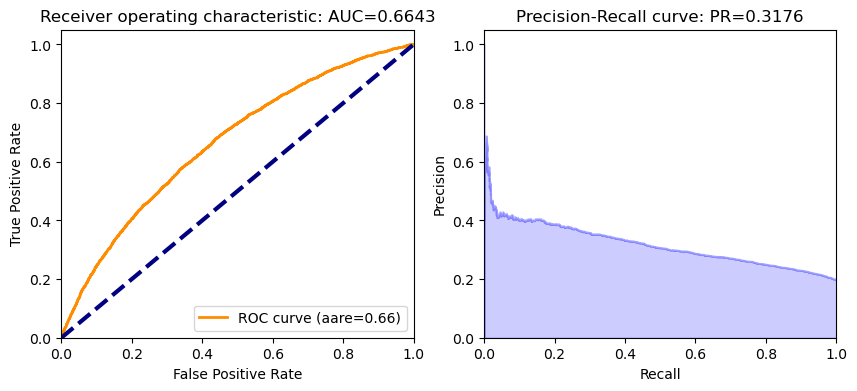

In [55]:
ROC_AUC(rf_v3,test_hex,'loan_default')

With a AUC of 0.6643, the ROC curve shows the h2o's 'balance classes' feature has little improvement to the test AUC and average precision.

In [56]:
createGains(rf_v3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,619,981,1600,619,981,0.20,0.08,315.0,1.97,12.0,38.69
1,1600,484,1116,3200,1103,2097,0.35,0.16,630.0,1.75,19.0,34.47
2,1600,392,1208,4800,1495,3305,0.47,0.26,945.0,1.58,21.0,31.15
3,1600,362,1238,6400,1857,4543,0.59,0.35,1260.0,1.47,24.0,29.02
4,1600,322,1278,8000,2179,5821,0.69,0.45,1575.0,1.38,24.0,27.24
5,1600,260,1340,9600,2439,7161,0.77,0.56,1890.0,1.29,21.0,25.41
6,1600,239,1361,11200,2678,8522,0.85,0.66,2205.0,1.21,19.0,23.91
7,1600,205,1395,12800,2883,9917,0.92,0.77,2520.0,1.14,15.0,22.52
8,1600,154,1446,14400,3037,11363,0.96,0.88,2835.0,1.07,8.0,21.09


### Undersampling
A simple under-sampling technique is to under-sample the majority class randomly and uniformly. This can potentially lead to the loss of information. But if the examples of the majority class are near to others, this method might yield good results.

In [58]:
y = data[target]
X = data.drop(target,axis=1)
y.dtypes

dtype('int64')

In [59]:
y1_cnt = data[target].sum()
y1_cnt

15488

In [60]:
N = 2
y0_cnt = y1_cnt * N
y0_cnt

30976

In [75]:
!pip install scikit_learn-1.1.dev0-cp39-cp39-macosx_11_0_universal2.whl

Processing ./scikit_learn-1.1.dev0-cp39-cp39-macosx_11_0_universal2.whl
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.2
    Uninstalling scikit-learn-1.1.2:
      Successfully uninstalled scikit-learn-1.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyod 1.0.5 requires numba>=0.51, but you have numba 0.47.0 which is incompatible.
imbalanced-learn 0.9.1 requires scikit-learn>=1.1.0, but you have scikit-learn 1.1.dev0 which is incompatible.


In [85]:
!pip install --no-use-pep517 scikit-learn"==1.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 7.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [876 lines of output]
      Partial import of sklearn during the build process.
      C compiler: clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/mac/opt/anaconda3/include -arch arm64 -I/Users/mac/opt/anaconda3/include -fPIC -O2 -isystem /Users/mac/opt/anaconda3/include -arch arm64
      
      compile options: '-c'
      clang: test_program.c
      clang -arch arm64 objects/test_program.o -o test_program
      C compiler: clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/mac/opt/anaconda3/include -arch arm64 -I/Users/mac/opt/anaconda3/include -fPIC -O2 -isystem /Users/mac/opt/anaconda3/include -arch arm64
      
  

Failed to build scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.2
    Uninstalling scikit-learn-1.1.2:
      Successfully uninstalled scikit-learn-1.1.2
  Running setup.py install for scikit-learn ... error
  error: subprocess-exited-with-error
  
  × Running setup.py install for scikit-learn did not run successfully.
  │ exit code: 1
  ╰─> [876 lines of output]
      Partial import of sklearn during the build process.
      C compiler: clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/mac/opt/anaconda3/include -arch arm64 -I/Users/mac/opt/anaconda3/include -fPIC -O2 -isystem /Users/mac/opt/anaconda3/include -arch arm64
      
      compile options: '-c'
      clang: test_program.c
      clang -arch arm64 objects/test_program.o -o test_program
      C compiler: clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/ma

      copying sklearn/linear_model/_passive_aggressive.py -> build/lib.macosx-11.1-arm64-3.9/sklearn/linear_model
      copying sklearn/linear_model/__init__.py -> build/lib.macosx-11.1-arm64-3.9/sklearn/linear_model
      copying sklearn/linear_model/_logistic.py -> build/lib.macosx-11.1-arm64-3.9/sklearn/linear_model
      copying sklearn/linear_model/_omp.py -> build/lib.macosx-11.1-arm64-3.9/sklearn/linear_model
      copying sklearn/linear_model/_perceptron.py -> build/lib.macosx-11.1-arm64-3.9/sklearn/linear_model
      copying sklearn/linear_model/setup.py -> build/lib.macosx-11.1-arm64-3.9/sklearn/linear_model
      copying sklearn/linear_model/_theil_sen.py -> build/lib.macosx-11.1-arm64-3.9/sklearn/linear_model
      copying sklearn/linear_model/_coordinate_descent.py -> build/lib.macosx-11.1-arm64-3.9/sklearn/linear_model
      copying sklearn/linear_model/_ridge.py -> build/lib.macosx-11.1-arm64-3.9/sklearn/linear_model
      copying sklearn/linear_model/_stochastic_gradien

In [80]:
!curl -fsSLo Miniforge3.sh "https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-MacOSX-$(uname -m).sh"

In [82]:
import imblearn
from imblearn.datasets import make_imbalance

AttributeError: module 'sklearn.metrics._dist_metrics' has no attribute 'DatasetsPair'

In [68]:
from imblearn.datasets import make_imbalance
X_rs, y_rs = make_imbalance(X, y, 
                            sampling_strategy={1:y1_cnt , 0:  y0_cnt},
                            random_state=0)
X_rs = pd.DataFrame(X_rs)
y_rs = pd.DataFrame(y_rs)  

AttributeError: module 'sklearn.metrics._dist_metrics' has no attribute 'DatasetsPair'

In [ ]:
y_rs = data[data[target]==1]
X_rs = data[data[target]==0].sample(n=y0_cnt)
smpl = pd.concat([X_rs,y_rs])
smpl_hex = h2o.H2OFrame(smpl)

#### [Back to the top](#0)

#### ROC

In [93]:
from sklearn.metrics import roc_curve, roc_auc_score
roc_auc_value = roc_auc_score(Y_test_afterWOE,y_pred_afterWOE)
roc_auc_value

0.6339520607353136

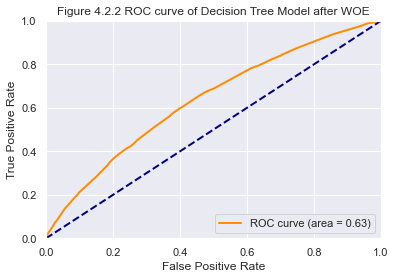

In [94]:
fpr, tpr, _ = roc_curve(Y_test_afterWOE, y_pred_afterWOE)
lw=2
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr, color='darkorange',lw=lw,label='ROC curve (area = %0.2f)' %roc_auc_value)
plt.plot([0,1],[0,1], color='navy',lw=lw,linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 4.2.2 ROC curve of Decision Tree Model after WOE')
plt.legend(loc='lower right')
plt.show()

Figure above shows that the AUC is 0.6319, which is slightly higher than the AUC of the firt model. It means the probability for the second model to distinguish between loan default and no default is slightly higher than the first model. 

## 5. Conclusion <a class="anchor" id="5"></a>
Describe why your feature transformation enhanced your model. Use a metric such as the standard ROC to show your model improvement. You do not need to perform the gains table or lift.

#### [Back to the top](#0)